# Creating Faster Kernel Functions
by doing multiple time steps in one kernel and using shared memory.
Shared memory is block-specific, so regions will have to be halo'd per block.
Making the block do as many cells as possible means less waste to halos.
One thread could do multiple cells/edges.
If the edges a thread does belong to the cell it does, it doesn't have to write back to memory to do both a norm vel + ssh tendency calculation and update.
If it does multiple cells, if those cells are neighbors, it could be possible to do both tendency calculations and updates, and then another tendency calculation.

In [1]:
CODE_ROOT = pwd() * "/"

"/home/rrs/Desktop/MPAS_Ocean/"

In [2]:
include(CODE_ROOT * "mode_init/mode_init.jl")

include(CODE_ROOT * "visualization.jl")

include(CODE_ROOT * "mode_forward/time_steppers.jl")

forward_euler_step_cuda! (generic function with 1 method)

In [3]:
using PyPlot, PyCall
animation  = pyimport("matplotlib.animation")
ipydisplay = pyimport("IPython.display")

PyObject <module 'IPython.display' from '/home/rrs/anaconda3/envs/MPAS_Ocean/lib/python3.8/site-packages/IPython/display.py'>

In [4]:
import CUDA

import CUDAKernels

import KernelAbstractions

# Load Mesh From File

In [5]:
mpasOcean = MPAS_Ocean(false, CODE_ROOT * "MPAS_O_Shallow_Water/Mesh+Initial_Condition+Registry_Files/Periodic",
                "base_mesh.nc", "mesh.nc", periodicity="Periodic"
)
typeof(mpasOcean)

MPAS_Ocean

# Define Initial Condition

In [6]:
function gaussianInit!(mpasOcean; sx=1/3, sy=1/3, mx=1/2, my=1/2)
    sigmax = mpasOcean.lX*sx
    sigmay = mpasOcean.lY*sy
    
    mux = mpasOcean.lX*mx
    muy = mpasOcean.lY*my
    
    for iCell in 1:mpasOcean.nCells
        mpasOcean.sshCurrent[iCell] = exp( - (mpasOcean.xCell[iCell] - mux)^2 / sigmax^2 - (mpasOcean.yCell[iCell] - muy)^2 / sigmay^2 )
    end
    
    mpasOcean.normalVelocityCurrent .= 0
    
    return nothing
end

gaussianInit! (generic function with 1 method)

In [7]:
function planeWaveInit!(mpasOcean; rkx = 1, rky = 1)
    kx = rkx * 2 * pi / mpasOcean.lX
    ky = rky * 2 * pi / mpasOcean.lY
    
    for iCell in 1:mpasOcean.nCells
        mpasOcean.sshCurrent[iCell] = cos( kx * mpasOcean.xCell[iCell] + ky * mpasOcean.yCell[iCell] )
    end
    
    mpasOcean.normalVelocityCurrent .= 0
    
    mpasOcean.sshTendency[:] .= mpasOcean.sshCurrent[:]
    mpasOcean.normalVelocityTendency[:] .= mpasOcean.normalVelocityCurrent[:]
    
    return nothing
end

planeWaveInit! (generic function with 1 method)

In [8]:
moveArrays!(mpasOcean, Array)

planeWaveInit!(mpasOcean) # could also do gaussianInit!

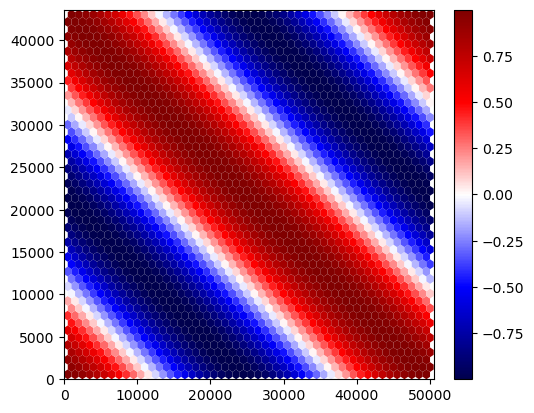

In [9]:
fig, ax, cbar, col = heatMapMesh(mpasOcean, mpasOcean.sshCurrent)
display(fig)

# Multi-timestep in one kernel with shared mem

In [10]:
function sharedArray(arr)
#     CUDA.@cushow size(arr)
#     s = Tuple(size(arr))
    tup = (100, 10)
    shared = CUDA.@cuStaticSharedMem(Float32, tup)
#     shared[threadIdx().x] = arr[threadIdx().x]
    return shared
end
function multi_fb_step_type_size_wrapper(
                                        normalVelocityTendencyT,
                                        normalVelocityT,
                                        sshTendencyT,
                                        sshT,
                                        cellsOnEdgeT,
                                        nEdgesOnEdgeT,
                                        edgesOnEdgeT,
                                        weightsOnEdgeT,
                                        nEdgesOnCellT,
                                        edgesOnCellT,
                                        cellsOnCellT,
                                        fEdgeT,
                                        bottomDepthT,
                                        dcEdgeT,
                                        dvEdgeT,
                                        areaCellT,
                                        edgeSignOnCellT,
                                    
                                        normalVelocityTendencySize,
                                        normalVelocitySize,
                                        sshTendencySize,
                                        sshSize,
                                        cellsOnEdgeSize,
                                        nEdgesOnEdgeSize,
                                        edgesOnEdgeSize,
                                        weightsOnEdgeSize,
                                        nEdgesOnCellSize,
                                        edgesOnCellSize,
                                        cellsOnCellSize,
                                        fEdgeSize,
                                        bottomDepthSize,
                                        dcEdgeSize,
                                        dvEdgeSize,
                                        areaCellSize,
                                        edgeSignOnCellSize,
                                    )
    # compiles the type and size of each array into the kernel definition
    return function multi_fb_step_kernel!(nSteps, dt, nEdges, nCells, gravity,

                                            normalVelocityTendencyG,
                                            normalVelocityG,
                                            sshTendencyG,
                                            sshG,
                                            cellsOnEdgeG,
                                            nEdgesOnEdgeG,
                                            edgesOnEdgeG,
                                            weightsOnEdgeG,
                                            nEdgesOnCellG,
                                            edgesOnCellG,
                                            cellsOnCellG,
                                            fEdgeG,
                                            bottomDepthG,
                                            dcEdgeG,
                                            dvEdgeG,
                                            areaCellG,
                                            edgeSignOnCellG)

        # allocate shared mem
        normalVelocityTendency = CUDA.@cuStaticSharedMem(normalVelocityTendencyT, normalVelocityTendencySize)
        normalVelocity         = CUDA.@cuStaticSharedMem(normalVelocityT, normalVelocitySize)
        sshTendency            = CUDA.@cuStaticSharedMem(sshTendencyT, sshTendencySize)
        ssh                    = CUDA.@cuStaticSharedMem(sshT, sshSize)
        cellsOnEdge            = CUDA.@cuStaticSharedMem(cellsOnEdgeT, cellsOnEdgeSize)
        nEdgesOnEdge           = CUDA.@cuStaticSharedMem(nEdgesOnEdgeT, nEdgesOnEdgeSize)
        edgesOnEdge            = CUDA.@cuStaticSharedMem(edgesOnEdgeT, edgesOnEdgeSize)
    #     weightsOnEdge          CUDA.@cuStaticSharedMemay(weightsOnEdgeT, weightsOnEdgeSize)
        nEdgesOnCell           = CUDA.@cuStaticSharedMem(nEdgesOnCellT, nEdgesOnCellSize)
        edgesOnCell            = CUDA.@cuStaticSharedMem(edgesOnCellT, edgesOnCellSize)
        cellsOnCell            = CUDA.@cuStaticSharedMem(cellsOnCellT, cellsOnCellSize)
        fEdge                  = CUDA.@cuStaticSharedMem(fEdgeT, fEdgeSize)
        bottomDepth            = CUDA.@cuStaticSharedMem(bottomDepthT, bottomDepthSize)
        dcEdge                 = CUDA.@cuStaticSharedMem(dcEdgeT, dcEdgeSize)
        dvEdge                 = CUDA.@cuStaticSharedMem(dvEdgeT, dvEdgeSize)
        areaCell               = CUDA.@cuStaticSharedMem(areaCellT, areaCellSize)
        edgeSignOnCell         = CUDA.@cuStaticSharedMem(edgeSignOnCellT, edgeSignOnCellSize)
        
        # move data to shared mem
        normalVelocityTendency[threadIdx().x] = normalVelocityTendencyG[threadIdx().x]
        normalVelocity[threadIdx().x]         = normalVelocityG[threadIdx().x]
        sshTendency[threadIdx().x]            = sshTendencyG[threadIdx().x]
        ssh[threadIdx().x]                    = sshG[threadIdx().x]
        cellsOnEdge[threadIdx().x]            = cellsOnEdgeG[threadIdx().x]
        nEdgesOnEdge[threadIdx().x]           = nEdgesOnEdgeG[threadIdx().x]
        edgesOnEdge[threadIdx().x]            = edgesOnEdgeG[threadIdx().x]
        weightsOnEdge[threadIdx().x]          = weightsOnEdgeG[threadIdx().x]
        nEdgesOnCell[threadIdx().x]           = nEdgesOnCellG[threadIdx().x]
        edgesOnCell[threadIdx().x]            = edgesOnCellG[threadIdx().x]
        cellsOnCell[threadIdx().x]            = cellsOnCellG[threadIdx().x]
        fEdge[threadIdx().x]                  = fEdgeG[threadIdx().x]
        bottomDepth[threadIdx().x]            = bottomDepthG[threadIdx().x]
        dcEdge[threadIdx().x]                 = dcEdgeG[threadIdx().x]
        dvEdge[threadIdx().x]                 = dvEdgeG[threadIdx().x]
        areaCell[threadIdx().x]               = areaCellG[threadIdx().x]
        edgeSignOnCell[threadIdx().x]         = edgeSignOnCellG[threadIdx().x]

        
        # perform time steps
        for i in 1:nSteps
    #         calculate_normal_velocity_tendency_cuda_kernel!(nEdges, normalVelocityTendency, normalVelocity, ssh, cellsOnEdge, nEdgesOnEdge, edgesOnEdge, weightsOnEdge, fEdge, dcEdge, gravity)

    #         update_normal_velocity_by_tendency_cuda_kernel!(nEdges, normalVelocity, dt, normalVelocityTendency)

    #         calculate_ssh_tendency_cuda_kernel!(nCells, sshTendency, ssh, normalVelocity, bottomDepth, nEdgesOnCell, edgesOnCell, cellsOnCell, areaCell, edgeSignOnCell, dvEdge)

    #         update_ssh_by_tendency_cuda_kernel!(nCells, ssh, dt, sshTendency)
        end

        # move data back
        normalVelocityTendencyG[threadIdx().x] = normalVelocityTendency[threadIdx().x]
        normalVelocityG[threadIdx().x]         = normalVelocity[threadIdx().x]
        sshTendencyG[threadIdx().x]            = sshTendency[threadIdx().x]
        sshG[threadIdx().x]                    = ssh[threadIdx().x]
        cellsOnEdgeG[threadIdx().x]            = cellsOnEdge[threadIdx().x]
        nEdgesOnEdgeG[threadIdx().x]           = nEdgesOnEdge[threadIdx().x]
        edgesOnEdgeG[threadIdx().x]            = edgesOnEdge[threadIdx().x]
        weightsOnEdgeG[threadIdx().x]          = weightsOnEdge[threadIdx().x]
        nEdgesOnCellG[threadIdx().x]           = nEdgesOnCell[threadIdx().x]
        edgesOnCellG[threadIdx().x]            = edgesOnCell[threadIdx().x]
        cellsOnCellG[threadIdx().x]            = cellsOnCell[threadIdx().x]
        fEdgeG[threadIdx().x]                  = fEdge[threadIdx().x]
        bottomDepthG[threadIdx().x]            = bottomDepth[threadIdx().x]
        dcEdgeG[threadIdx().x]                 = dcEdge[threadIdx().x]
        dvEdgeG[threadIdx().x]                 = dvEdge[threadIdx().x]
        areaCellG[threadIdx().x]               = areaCell[threadIdx().x]
        edgeSignOnCellG[threadIdx().x]         = edgeSignOnCell[threadIdx().x]

        return
    end
end

multi_fb_step_type_size_wrapper (generic function with 1 method)

In [11]:
multi_fb_step_kernel! = multi_fb_step_type_size_wrapper(
        eltype(mpasOcean.normalVelocityTendency),
        eltype(mpasOcean.normalVelocityCurrent),
        eltype(mpasOcean.sshTendency),
        eltype(mpasOcean.sshCurrent),
        eltype(mpasOcean.cellsOnEdge),
        eltype(mpasOcean.nEdgesOnEdge),
        eltype(mpasOcean.edgesOnEdge),
        eltype(mpasOcean.weightsOnEdge),
        eltype(mpasOcean.nEdgesOnCell),
        eltype(mpasOcean.edgesOnCell),
        eltype(mpasOcean.cellsOnCell),
        eltype(mpasOcean.fEdge),
        eltype(mpasOcean.bottomDepth),
        eltype(mpasOcean.dcEdge),
        eltype(mpasOcean.dvEdge),
        eltype(mpasOcean.areaCell),
        eltype(mpasOcean.edgeSignOnCell),

        size(mpasOcean.normalVelocityTendency),
        size(mpasOcean.normalVelocityCurrent),
        size(mpasOcean.sshTendency),
        size(mpasOcean.sshCurrent),
        size(mpasOcean.cellsOnEdge),
        size(mpasOcean.nEdgesOnEdge),
        size(mpasOcean.edgesOnEdge),
        size(mpasOcean.weightsOnEdge),
        size(mpasOcean.nEdgesOnCell),
        size(mpasOcean.edgesOnCell),
        size(mpasOcean.cellsOnCell),
        size(mpasOcean.fEdge),
        size(mpasOcean.bottomDepth),
        size(mpasOcean.dcEdge),
        size(mpasOcean.dvEdge),
        size(mpasOcean.areaCell),
        size(mpasOcean.edgeSignOnCell),
    )

multi_fb_step_kernel! (generic function with 1 method)

In [12]:
# CUDA.@device_code_warntype
CUDA.@cuda blocks=1 threads=1024 multi_fb_step_kernel!(25,
                                                        mpasOcean.dt,
                                                        mpasOcean.nEdges, mpasOcean.nCells,
                                                        mpasOcean.gravity,
        
                                                        mpasOcean.normalVelocityTendency,
                                                        mpasOcean.normalVelocityCurrent,
                                                        mpasOcean.sshTendency,
                                                        mpasOcean.sshCurrent,
                                                        mpasOcean.cellsOnEdge,
                                                        mpasOcean.nEdgesOnEdge,
                                                        mpasOcean.edgesOnEdge,
                                                        mpasOcean.weightsOnEdge,
                                                        mpasOcean.nEdgesOnCell,
                                                        mpasOcean.edgesOnCell,
                                                        mpasOcean.cellsOnCell,
                                                        mpasOcean.fEdge,
                                                        mpasOcean.bottomDepth,
                                                        mpasOcean.dcEdge,
                                                        mpasOcean.dvEdge,
                                                        mpasOcean.areaCell,
                                                        mpasOcean.edgeSignOnCell)

LoadError: CUDA error (code 999, CUDA_ERROR_UNKNOWN)